# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [34]:
# Load the libraries as required.
%matplotlib inline
import pandas as pd
import numpy as np
if not hasattr(np, 'bool'):
    np.bool = bool
if not hasattr(np, 'int'):
    np.int = int
if not hasattr(np, 'float'):
    np.float = float

In [35]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [36]:
fires_dt

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# Get X and Y

Create the features data frame and target data.

In [37]:
# Create the features dataframe by dropping the 'area' column.
features = fires_dt.drop(columns = ['area'])
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
dtypes: float64(7), int64(3), object(2)
memory usage: 48.6+ KB


In [38]:
# Create the target dataframe by selecting the 'area' column.
target = fires_dt['area']
target.info()

<class 'pandas.core.series.Series'>
RangeIndex: 517 entries, 0 to 516
Series name: area
Non-Null Count  Dtype  
--------------  -----  
517 non-null    float64
dtypes: float64(1)
memory usage: 4.2 KB


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define the numerical features
numerical_features = [
    'coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain'
]

# Define the categorical features
categorical_features = [
  'month', 'day',
]

# Create the preprocessor
preproc1 = ColumnTransformer(
    transformers = [
        ('numerical_transformer', StandardScaler(), numerical_features),     
        ('categorical_encoder', OneHotEncoder(handle_unknown = 'ignore'), categorical_features)
    ]
)

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

# Define the numerical features to be transformed
num_transformed = [
    'temp', 'rh', 'wind', 'rain'
]

# Define a pipeline for numerical features to be scaled
num_scale_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

# Define a pipeline for numerical features to be scaled and transfromed
num_transform_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nonlinear_transformer', PowerTransformer()) 
])

# Define a pipeline for categorical features
categorical_pipeline = Pipeline([
    ('cat_encoder', OneHotEncoder(handle_unknown = 'ignore'))
])

# Create the preprocessor with the new pipelines
preproc2 = ColumnTransformer(
    transformers = [
        ('numerical_scaler', num_scale_pipeline, numerical_features),
        ('numerical_transformer', num_transform_pipeline, num_transformed),  
        ('categorical_encoder', categorical_pipeline, categorical_features)
    ]
)

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [41]:
from sklearn.neighbors import KNeighborsRegressor

# Pipeline A = preproc1 + baseline

# Instantiate a KNN regressor as a baseline regressor
baseline_knn_regressor = KNeighborsRegressor(n_neighbors = 5)

pipeline_A = Pipeline([
    ('preprocessor', preproc1),
    ('regressor', baseline_knn_regressor)
])

In [42]:
# Pipeline B = preproc2 + baseline

pipeline_B = Pipeline([
    ('preprocessor', preproc2),
    ('regressor', baseline_knn_regressor)
])

In [43]:
from sklearn.ensemble import BaggingRegressor

# Pipeline C = preproc1 + advanced model

# Instantiate a bagging regressor as an advanced regressor
advanced_regressor = BaggingRegressor(
    n_estimators = 10,
    random_state = 42
)

pipeline_C = Pipeline([
    ('preprocessor', preproc1),
    ('regressor', advanced_regressor)
])

In [44]:
# Pipeline D = preproc2 + advanced model

pipeline_D = Pipeline([
    ('preprocessor', preproc2),
    ('regressor', advanced_regressor)
])    

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Define the parameter grid for Pipelines A and B
# Tuning 'n_neighbors' for KNeighborsRegressor
param_grid_A = {
    'regressor__n_neighbors': range(1,51)
}

param_grid_B = {
    'regressor__n_neighbors': range(1,51)
}

# Define the parameter grid for Pipelines C and D
# Tuning 'n_estimators' and 'max_samples' for BaggingRegressor (default estimator is DecisionTreeRegressor)
# 'n_estimators' controls the number of base estimators (trees) in the ensemble
# 'max_samples' controls the fraction of samples to draw from features to train each base estimator

param_grid_C = {
    'regressor__n_estimators': [5, 10, 20, 50],
    'regressor__max_samples': [0.5, 0.7, 1.0]
}

param_grid_D = {
    'regressor__n_estimators': [5, 10, 20, 50],
    'regressor__max_samples': [0.5, 0.7, 1.0]
}

# Split the data into training and testing sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

# Define GridSearchCV objects for all pipelines
# Each GridSearchCV will search for the best hyperparameters based on the specified scoring metric
# 'neg_root_mean_squared_error' is chosen as a metric to evaluate the model performance

grid_search_A = GridSearchCV(
    estimator = pipeline_A,
    param_grid = param_grid_A,
    scoring = 'neg_root_mean_squared_error', 
    cv = 5,                                  
)

grid_search_B = GridSearchCV(
    estimator = pipeline_B,
    param_grid = param_grid_B,
    scoring = 'neg_root_mean_squared_error', 
    cv = 5,                                  
)

grid_search_C = GridSearchCV(
    estimator = pipeline_C,
    param_grid = param_grid_C,
    scoring = 'neg_root_mean_squared_error',
    cv = 5
)

grid_search_D = GridSearchCV(
    estimator = pipeline_D,
    param_grid = param_grid_D,
    scoring = 'neg_root_mean_squared_error',
    cv = 5
)

In [46]:
# Check the type of features_train and its columns
print(type(features_train))
print(features_train.columns)

<class 'pandas.core.frame.DataFrame'>
Index(['coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi',
       'temp', 'rh', 'wind', 'rain'],
      dtype='object')


In [47]:
# Fit GridSearchCV on the training data
grid_search_A.fit(features_train, target_train)
grid_search_B.fit(features_train, target_train)
grid_search_C.fit(features_train, target_train)
grid_search_D.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical_scaler',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('numerical_transformer',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('nonlinear_transformer',
                                                                                          PowerTransformer())]),
                                                                         ['temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('categorical_encoder',
                                                                         Pipeline(steps=[('cat_encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        BaggingRegressor(random_state=42))]),
             param_grid={'regressor__max_samples': [0.5, 0.7, 1.0],
                         'regressor__n_estimators': [5, 10, 20, 50]},
             scoring='neg_root_mean_squared_error')

In [48]:
# Print the best hyperparameters found for all pipelines
print("Best hyperparameters for Pipeline A:", grid_search_A.best_params_)
print("Best hyperparameters for Pipeline B:", grid_search_B.best_params_)
print("Best hyperparameters for Pipeline C:", grid_search_C.best_params_)
print("Best hyperparameters for Pipeline D:", grid_search_D.best_params_)

Best hyperparameters for Pipeline A: {'regressor__n_neighbors': 40}
Best hyperparameters for Pipeline B: {'regressor__n_neighbors': 49}
Best hyperparameters for Pipeline C: {'regressor__max_samples': 0.5, 'regressor__n_estimators': 50}
Best hyperparameters for Pipeline D: {'regressor__max_samples': 0.5, 'regressor__n_estimators': 50}


In [49]:
# Print the best estimator (the fitted pipeline with optimal hyperparameters)
print("Best estimator for Pipeline A:", grid_search_A.best_estimator_)
print("Best estimator for Pipeline B:", grid_search_B.best_estimator_)
print("Best estimator for Pipeline C:", grid_search_C.best_estimator_)
print("Best estimator for Pipeline D:", grid_search_D.best_estimator_)

Best estimator for Pipeline A: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_transformer',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', KNeighborsRegressor(n_neighbors=40))])
Best estimator for Pipeline B: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_scaler',
                                                  Pipeline(steps=[('scaler',
                                           

In [50]:
# Print the best scores (negative RMSE) for all pipelines
print("Best RMSE (A):", -grid_search_A.best_score_)
print("Best RMSE (B):", -grid_search_B.best_score_)
print("Best RMSE (C):", -grid_search_C.best_score_)
print("Best RMSE (D):", -grid_search_D.best_score_)

Best RMSE (A): 38.29523211958792
Best RMSE (B): 38.244623744176394
Best RMSE (C): 46.0161757033171
Best RMSE (D): 46.01609519499783


# Evaluate

+ Which model has the best performance?

In [51]:
# Evaluate best models on test data
best_model_A = grid_search_A.best_estimator_
best_model_B = grid_search_B.best_estimator_
best_model_C = grid_search_C.best_estimator_
best_model_D = grid_search_D.best_estimator_

from sklearn.metrics import root_mean_squared_error

# Predict on the test set
predictions_A = best_model_A.predict(features_test)
predictions_B = best_model_B.predict(features_test)
predictions_C = best_model_C.predict(features_test)
predictions_D = best_model_D.predict(features_test)

# Calculate RMSE for each model
rmse_A = root_mean_squared_error(target_test, predictions_A)
rmse_B = root_mean_squared_error(target_test, predictions_B)
rmse_C = root_mean_squared_error(target_test, predictions_C)
rmse_D = root_mean_squared_error(target_test, predictions_D)

rmse_values = {
    'Pipeline A': rmse_A,
    'Pipeline B': rmse_B,
    'Pipeline C': rmse_C,
    'Pipeline D': rmse_D  
}

# Print RMSE values for each model
print("\nRMSE values for each model:")
for model, rmse in rmse_values.items():
    print(f"{model}: {rmse:.2f}")
    
# The best model is the one with the lowest RMSE
best_model = min(rmse_values, key=rmse_values.get)
print(f"The best model is {best_model} with RMSE: {rmse_values[best_model]:.2f}")


RMSE values for each model:
Pipeline A: 108.76
Pipeline B: 109.16
Pipeline C: 109.36
Pipeline D: 109.87
The best model is Pipeline A with RMSE: 108.76


# Export

+ Save the best performing model to a pickle file.

In [52]:
import pickle

model_dict = {
    'Pipeline A': best_model_A,
    'Pipeline B': best_model_B,
    'Pipeline C': best_model_C,
    'Pipeline D': best_model_D
}

# Save the best model to a file using pickle
with open("best_model.pkl", "wb") as f:
    pickle.dump(model_dict[best_model], f)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [53]:
import shap

best_pipeline = model_dict[best_model]

# Transform the test features using the pipeline's preprocessor
data_transform = best_pipeline.named_steps['preprocessor'].transform(features_test)

# Get the regressor from the best pipeline
regressor = best_pipeline.named_steps['regressor']

# Get the feature names from the preprocessor
feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a SHAP explainer for the best model
explainer = shap.Explainer(regressor.predict, data_transform)
shap_values = explainer(data_transform)

PermutationExplainer explainer: 105it [00:14,  2.18it/s]                         


/tmp/ipykernel_27321/867885784.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, data_transform, feature_names=feature_names, plot_type="dot")


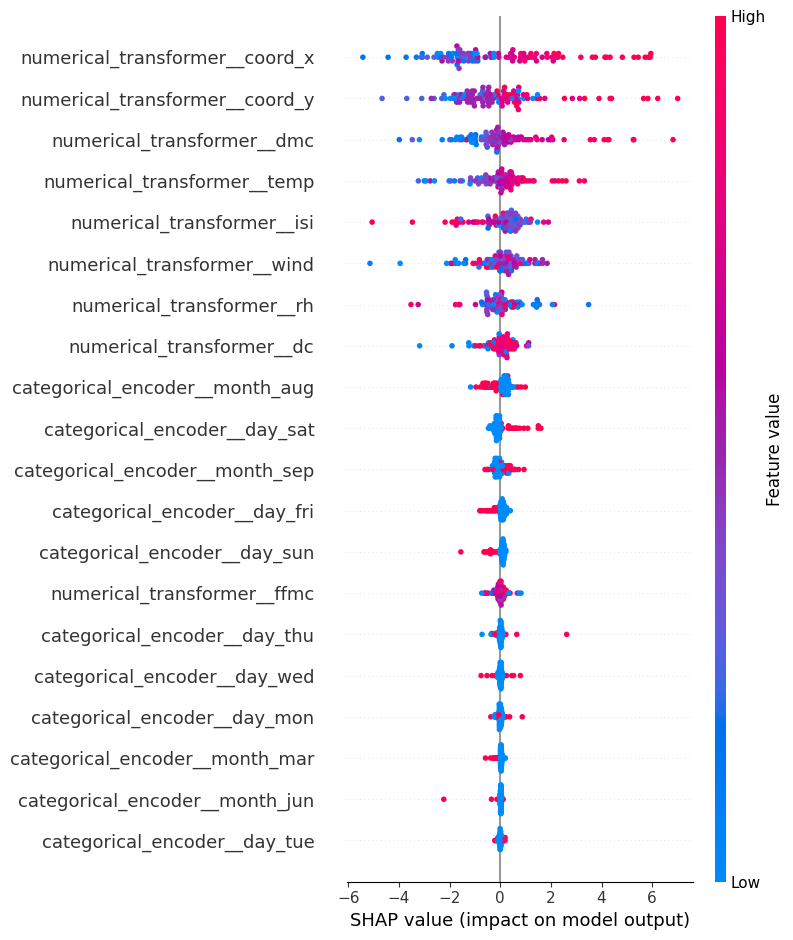

In [54]:
shap.summary_plot(shap_values, data_transform, feature_names=feature_names, plot_type="dot")

/home/labber/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/home/labber/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/home/labber/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/home/labber/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/home/labber/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names,

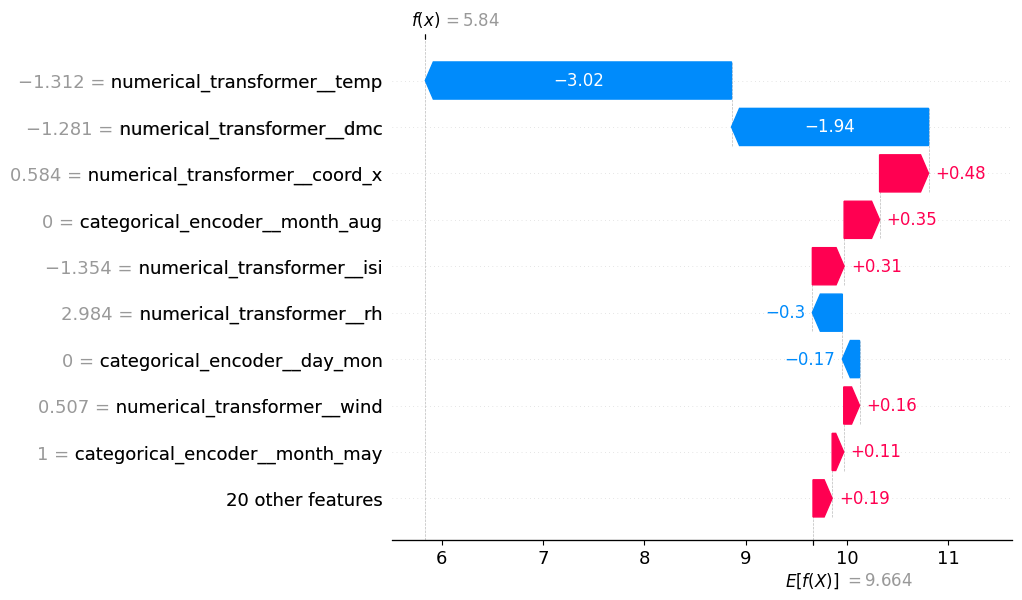

In [55]:
# Convert the transformed data to a DataFrame with feature names
data_transform_df = pd.DataFrame(
    data_transform, columns=feature_names, index=features_test.index
)

# Create the SHAP explainer using the DataFrame
explainer = shap.Explainer(regressor.predict, data_transform_df)
shap_values = explainer(data_transform_df)

# Now the waterfall plot will show feature names
shap.plots.waterfall(shap_values[0])

> Selecting the first observation in the test, the most important features that explain the observation's specific predition is temperature and DMC index.  Both features decrease the model's prediction, ie., push the predicted value lower than the model's expected value.

> Across the complete training set, the most important features are x and y coordinates within the Montesinho park map and DMC index while the least important features are the month June and day Tuesday.

> If I were to remove features from the model, I would remove the month and day (categorical) features. To confirm this, they can be removed with the model retested or the model could be tested with only these features present.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.